In [3]:
import os, sys, json, pickle, joblib
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

# ---- paths/config ------------------------------------------------------------
PROJECT_DIR = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER"
DEV_DIR     = os.path.join(PROJECT_DIR, "dev/transformer")
sys.path.append(DEV_DIR)

from transformer import MultiomicTransformer
from transformer_dataset import MultiomicTransformerDataset
from transformer_training import prepare_dataloader

TRAINED_MODEL_SAMPLE_NAME = "mESC"
EVAL_SAMPLE_NAME          = "mESC_holdout"
CHROM_ID                  = "chr1"

OUTPUT_DIR                = os.path.join(PROJECT_DIR, "output/transformer_testing_output")
TRAINED_MODEL_DIR         = os.path.join(OUTPUT_DIR, "mESC/chr1/model_training_29_09_17_51_50/iter1")
COMMON_DATA_DIR           = os.path.join(DEV_DIR, "transformer_data", "common")

TRAINED_MODEL_DATASET_DIR = os.path.join(DEV_DIR, f"transformer_data/{TRAINED_MODEL_SAMPLE_NAME}")
EVAL_DATASET_DIR          = os.path.join(DEV_DIR, f"transformer_data/{EVAL_SAMPLE_NAME}")

CAL_SPLIT_FRAC = 0.5   # fraction of eval cells for fitting calibrator (rest is test)
CAL_ALPHAS     = [0.1, 0.3, 1.0, 3.0, 10.0]
BATCH_SIZE_FALLBACK = 64  # used if run_params missing or too small
SEED = 42

# ---- helpers ----------------------------------------------------------------
def set_seed(seed=SEED):
    import random
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

def inv_tr(X, mean, scale):
    X = np.asarray(X, dtype=np.float32)
    if scale is not None: X = X * scale
    if mean  is not None: X = X + mean
    return X

def run_model(model, loader, device, zscore_tf=True):
    """Return preds/true in the dataset's z-space (preds are in TRAIN z-space by construction)."""
    preds_all, true_all = [], []
    model.eval()
    with torch.no_grad():
        for atac_wins, tf_tensor, tg_true, bias, tf_ids, tg_ids in loader:
            atac_wins = atac_wins.to(device)
            tf_tensor = tf_tensor.to(device)
            tg_true   = tg_true.to(device)
            bias      = bias.to(device)
            tf_ids    = tf_ids.to(device)
            tg_ids    = tg_ids.to(device)

            if zscore_tf:
                mu = tf_tensor.mean(dim=1, keepdim=True)
                sd = tf_tensor.std(dim=1, keepdim=True).clamp_min(1e-6)
                tf_tensor = (tf_tensor - mu) / sd

            preds = model(atac_wins, tf_tensor, tf_ids=tf_ids, tg_ids=tg_ids, bias=bias)  # [B,G_eval]
            preds_all.append(preds.cpu().numpy())
            true_all.append(tg_true.cpu().numpy())
    return np.vstack(preds_all), np.vstack(true_all)

def build_overlap_and_spaces(preds, true, dataset, train_dataset_dir):
    """Align gene order, inverse-transform to raw spaces, and map truth to TRAIN z-space."""
    train_scaler = joblib.load(Path(train_dataset_dir) / f"{CHROM_ID}/tg_scaler_{CHROM_ID}.pkl")
    eval_scaler  = dataset.scaler

    with open(Path(train_dataset_dir) / f"{CHROM_ID}/tg_names_{CHROM_ID}.json") as f:
        train_tg_names = json.load(f)

    train_name_to_idx = {g:i for i,g in enumerate(train_tg_names)}
    eval_name_to_idx  = {g:i for i,g in enumerate(dataset.tg_names)}

    overlap_genes = [g for g in dataset.tg_names if g in train_name_to_idx]
    mask_eval = np.array([g in train_name_to_idx for g in dataset.tg_names], dtype=bool)
    train_idx = np.array([train_name_to_idx[g] for g in overlap_genes])
    eval_idx  = np.array([eval_name_to_idx[g]  for g in overlap_genes])

    # slice to overlap
    preds_ov = preds[:, mask_eval]   # TRAIN z-space
    true_ov  = true[:,  mask_eval]   # EVAL  z-space

    # to raw
    preds_raw = inv_tr(preds_ov, train_scaler.mean_[train_idx], train_scaler.scale_[train_idx])
    true_raw  = inv_tr(true_ov,  eval_scaler.mean_[eval_idx],   eval_scaler.scale_[eval_idx])

    # truth in TRAIN z-space (apples-to-apples w/ preds_ov)
    true_in_train_z = (true_raw - train_scaler.mean_[train_idx]) / train_scaler.scale_[train_idx]

    return {
        "overlap_genes": overlap_genes,
        "preds_ov": preds_ov,
        "true_ov": true_ov,
        "preds_raw": preds_raw,
        "true_raw": true_raw,
        "true_in_train_z": true_in_train_z,
        "train_scaler": train_scaler,
        "train_idx": train_idx
    }

def split_for_calibration(X, Y, frac=CAL_SPLIT_FRAC, seed=SEED):
    """Split rows into (calibration, evaluation) to avoid leakage."""
    n = X.shape[0]
    rng = np.random.RandomState(seed)
    idx = rng.permutation(n)
    k  = int(np.floor(frac * n))
    cal, test = idx[:k], idx[k:]
    return (X[cal], Y[cal]), (X[test], Y[test])

def fit_ridge_calibrator(X_cal, Y_cal, alphas=CAL_ALPHAS):
    """Multi-output Ridge with simple CV on the calibration split."""
    from sklearn.linear_model import Ridge
    from sklearn.model_selection import KFold
    best_alpha, best_r = None, -np.inf
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    for a in alphas:
        rs = []
        for tr, va in kf.split(X_cal):
            rr = Ridge(alpha=a, fit_intercept=True)
            rr.fit(X_cal[tr], Y_cal[tr])
            yhat = rr.predict(X_cal[va])
            rs.append(np.corrcoef(Y_cal[va].ravel(), yhat.ravel())[0,1])
        r_mean = float(np.mean(rs))
        if r_mean > best_r: best_r, best_alpha = r_mean, a
    ridge = Ridge(alpha=best_alpha, fit_intercept=True)
    ridge.fit(X_cal, Y_cal)
    return ridge, best_alpha, best_r

def metrics_block(y, yhat, title=""):
    r_p = pearsonr(y.ravel(), yhat.ravel())[0]
    r_s = spearmanr(y.ravel(), yhat.ravel()).correlation
    mae = np.mean(np.abs(y - yhat))
    return {"pearson": float(r_p), "spearman": float(r_s), "mae": float(mae), "title": title}

def scatter_plot(y, yhat, title, out_png, max_points=5000):
    n = min(max_points, y.shape[0])
    idx = np.random.RandomState(SEED).choice(y.shape[0], n, replace=False)
    plt.figure(figsize=(6.5,6.5))
    plt.scatter(y[idx].ravel(), yhat[idx].ravel(), alpha=0.25, s=12)
    lims = [min(y.min(), yhat.min()), max(y.max(), yhat.max())]
    plt.plot(lims, lims, 'r--', linewidth=1)
    rp = pearsonr(y.ravel(), yhat.ravel())[0]
    plt.title(f"{title}\nPearson r = {rp:.2f}")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.tight_layout()
    plt.savefig(out_png, dpi=150); plt.close()

# ---- main -------------------------------------------------------------------
set_seed()

# 1) load run params + model
with open(os.path.join(TRAINED_MODEL_DIR, "run_parameters.json")) as f:
    run_params = json.load(f)
D_MODEL   = run_params["d_model"]
NUM_HEADS = run_params["Attention Heads"]
NUM_LAYERS= run_params["Model Layers"]
D_FF      = run_params["d_feedforward"]
DROPOUT   = run_params["Dropout"]
BATCH     = run_params.get("Batch Size", BATCH_SIZE_FALLBACK)

ckpt_path = os.path.join(TRAINED_MODEL_DIR, "checkpoint.pt")

# 2) vocabs (common)
with open(os.path.join(COMMON_DATA_DIR, "tf_vocab.json")) as f: tf_vocab = json.load(f)
with open(os.path.join(COMMON_DATA_DIR, f"tg_vocab_{CHROM_ID}.json")) as f: tg_vocab = json.load(f)
tf_vocab_size, tg_vocab_size = len(tf_vocab), len(tg_vocab)

# 3) eval dataset + loaders
dataset = MultiomicTransformerDataset(
    data_dir=EVAL_DATASET_DIR,
    chrom_id=CHROM_ID,
    tf_vocab_path=os.path.join(COMMON_DATA_DIR, "tf_vocab.json"),
    tg_vocab_path=os.path.join(COMMON_DATA_DIR, f"tg_vocab_{CHROM_ID}.json"),
)
train_loader, val_loader, test_loader = prepare_dataloader(dataset, batch_size=BATCH, world_size=1, rank=0)

# 4) model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MultiomicTransformer(
    d_model=D_MODEL, num_heads=NUM_HEADS, num_layers=NUM_LAYERS,
    d_ff=D_FF, dropout=DROPOUT,
    tf_vocab_size=tf_vocab_size, tg_vocab_size=tg_vocab_size,
    use_shortcut=True
).to(device)
state_dict = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state_dict, strict=True)

# 5) forward pass on ALL eval cells (z-scored TFs)
preds, true = run_model(model, test_loader, device, zscore_tf=True)

# 6) overlap alignment + spaces
spaces = build_overlap_and_spaces(preds, true, dataset, TRAINED_MODEL_DATASET_DIR)
overlap_genes   = spaces["overlap_genes"]
preds_ov        = spaces["preds_ov"]          # TRAIN z-space
true_in_train_z = spaces["true_in_train_z"]   # TRAIN z-space
preds_raw       = spaces["preds_raw"]         # raw DS011 after train inverse
true_raw        = spaces["true_raw"]
train_scaler    = spaces["train_scaler"]
train_idx       = spaces["train_idx"]

# 7) baseline metrics (train z-space & raw)
base_train = metrics_block(true_in_train_z, preds_ov, "Pre-calibration (train z-space)")
base_raw   = metrics_block(true_raw,       preds_raw, "Pre-calibration (raw DS011)")

# 8) calibration without leakage (split eval rows)
(X_cal, Y_cal), (X_test, Y_test) = split_for_calibration(preds_ov, true_in_train_z, frac=CAL_SPLIT_FRAC, seed=SEED)
ridge, best_alpha, cv_r = fit_ridge_calibrator(X_cal, Y_cal, alphas=CAL_ALPHAS)

# apply to test split
preds_test_cal = ridge.predict(X_test)  # still in TRAIN z-space
cal_train = metrics_block(Y_test, preds_test_cal, "Post-calibration (train z-space, test split)")

# also view in raw DS011
preds_test_cal_raw = inv_tr(preds_test_cal, train_scaler.mean_[train_idx], train_scaler.scale_[train_idx])
Y_test_raw         = inv_tr(Y_test,         train_scaler.mean_[train_idx], train_scaler.scale_[train_idx])
cal_raw = metrics_block(Y_test_raw, preds_test_cal_raw, "Post-calibration (raw DS011, test split)")

# 9) save artifacts/plots
out_dir = os.path.join(OUTPUT_DIR, f"infer_{EVAL_SAMPLE_NAME}_{CHROM_ID}")
os.makedirs(out_dir, exist_ok=True)

joblib.dump(ridge, os.path.join(out_dir, f"ridge_calibrator_alpha{best_alpha}.pkl"))
pd.DataFrame({
    "metric": ["pearson","spearman","mae"],
    "pre_train": [base_train["pearson"], base_train["spearman"], base_train["mae"]],
    "pre_raw":   [base_raw["pearson"],   base_raw["spearman"],   base_raw["mae"]],
    "post_train":[cal_train["pearson"],  cal_train["spearman"],  cal_train["mae"]],
    "post_raw":  [cal_raw["pearson"],    cal_raw["spearman"],    cal_raw["mae"]],
}).to_csv(os.path.join(out_dir, "metrics.csv"), index=False)

# plots
scatter_plot(Y_test_raw, preds_test_cal_raw,
             f"{EVAL_SAMPLE_NAME} {CHROM_ID}: Predicted vs Actual (calibrated, test split)",
             os.path.join(out_dir, "scatter_calibrated_test.png"))

# per-gene correlation on test split (raw)
gene_corr = []
for j, g in enumerate(overlap_genes):
    y = Y_test_raw[:, j]; yhat = preds_test_cal_raw[:, j]
    r = pearsonr(y, yhat)[0] if np.std(y) > 1e-8 else 0.0
    gene_corr.append((g, r))
pd.DataFrame(gene_corr, columns=["gene","pearson"]).sort_values("pearson", ascending=False)\
  .to_csv(os.path.join(out_dir, "per_gene_pearson_test.csv"), index=False)

# save matrices (test split, raw)
pd.DataFrame(preds_test_cal_raw, columns=overlap_genes)\
  .to_csv(os.path.join(out_dir, "predictions_calibrated_test.csv"), index=False)
pd.DataFrame(Y_test_raw, columns=overlap_genes)\
  .to_csv(os.path.join(out_dir, "truth_raw_test.csv"), index=False)

print("\n== Summary ==")
print(f"Baseline train z-space r: {base_train['pearson']:.3f}")
print(f"Baseline raw DS011 r:     {base_raw['pearson']:.3f}")
print(f"Calibrated train z r:     {cal_train['pearson']:.3f}")
print(f"Calibrated raw r:         {cal_raw['pearson']:.3f}  (alpha={best_alpha}, CV r={cv_r:.3f})")
print(f"Artifacts in: {out_dir}")


RuntimeError: Error(s) in loading state_dict for MultiomicTransformer:
	size mismatch for tg_emb_table.weight: copying a param with shape torch.Size([25120, 384]) from checkpoint, the shape in current model is torch.Size([1425, 384]).
	size mismatch for tg_decoder_table.weight: copying a param with shape torch.Size([25120, 384]) from checkpoint, the shape in current model is torch.Size([1425, 384]).

TF overlap: 262
TG count (eval): 189


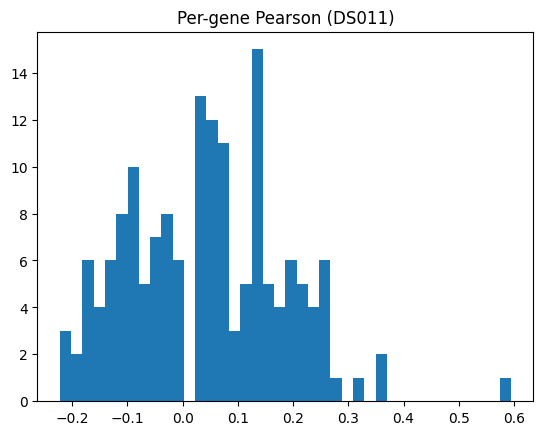

Median per-gene r: 0.045425191896724317


In [3]:
print("TF overlap:", len([t for t in dataset.tf_names if t in tf_vocab]))
print("TG count (eval):", len(dataset.tg_names))

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
per_gene = [pearsonr(true_raw[:,j], preds_raw[:,j])[0] if np.std(true_raw[:,j])>1e-8 else 0.0
            for j in range(preds_raw.shape[1])]
plt.hist(per_gene, bins=40); plt.title("Per-gene Pearson (DS011)"); plt.show()
print("Median per-gene r:", np.median(per_gene))


In [4]:
from sklearn.linear_model import Ridge
N = preds_ov.shape[0]
idx = np.random.RandomState(0).randint(0,2,size=N).astype(bool)
reg = Ridge(alpha=1.0).fit(preds_ov[idx], true_in_train_z[idx])
preds_cal = reg.predict(preds_ov[~idx])
r = np.corrcoef(preds_cal.ravel(), true_in_train_z[~idx].ravel())[0,1]
print("Pearson after ridge calibration:", round(r,3))

Pearson after ridge calibration: 0.271


In [5]:
model.eval()
for p in model.tf_emb_table.parameters(): p.requires_grad=False
for p in model.tg_emb_table.parameters(): p.requires_grad=False
for p in model.tg_decoder_table.parameters(): p.requires_grad=False
for p in model.encoder.parameters(): p.requires_grad=False

trainable = list(model.out_dense.parameters())
if hasattr(model, "shortcut_scale"):
    trainable += [model.shortcut_scale]
opt = torch.optim.Adam(trainable, lr=1e-4, weight_decay=1e-4)

# quick loop (5–10 epochs) on DS011 train split with MSE on z-space targets


In [6]:
sd_ratio = np.std(preds_raw,0) / np.clip(np.std(true_raw,0), 1e-6, None)
bad = [(g, r, s) for g,r,s in zip(dataset.tg_names, per_gene, sd_ratio)]
bad.sort(key=lambda x: x[1])  # lowest r first
print("Worst 10 genes:", bad[:10])

Worst 10 genes: [('Lgr6', np.float64(-0.22220699333166521), np.float64(1.7548341562169596)), ('Cadm3', np.float64(-0.22121843738933739), np.float64(0.5634886508677992)), ('Plxna2', np.float64(-0.20193127345428796), np.float64(0.6482968068468365)), ('Nmnat2', np.float64(-0.19767455202192438), np.float64(1.8375082048863023)), ('Nos1ap', np.float64(-0.18555702032206745), np.float64(1.0255259683838551)), ('Gulp1', np.float64(-0.1788826705706547), np.float64(1.7308196354079923)), ('Rgs20', np.float64(-0.17721879440007843), np.float64(1.6943327399907808)), ('Paqr8', np.float64(-0.16993688369158352), np.float64(0.8894929622950064)), ('Astn1', np.float64(-0.1644960022645811), np.float64(1.659518986525713)), ('Gm16070', np.float64(-0.16387266733828978), np.float64(0.8031445683986057))]


In [13]:
from sklearn.linear_model import Ridge
import joblib
import numpy as np

# X = model outputs in TRAIN z-space (preds_ov)
# Y = DS011 truth transformed into TRAIN z-space (true_in_train_z)

N = preds_ov.shape[0]
rng = np.random.default_rng(0)
mask = rng.random(N) < 0.5        # 50/50 split

ridge = Ridge(alpha=1.0, fit_intercept=True)
ridge.fit(preds_ov[mask], true_in_train_z[mask])

# Save for later use
joblib.dump(ridge, os.path.join(out_dir, "ridge_calibrator.pkl"))

# Use it
preds_cal = ridge.predict(preds_ov)             # still in TRAIN z-space
# If you want raw-space values aligned to DS011 truth:
preds_cal_raw = preds_cal * train_scaler.scale_[train_idx] + train_scaler.mean_[train_idx]
